## LDA Implementation


1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

**This is just a copy from the orignial file**  https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

### 1. Loading data

In [1]:
import pandas as pd
import os 
import numpy as np

os.chdir('C:/Users/alexa/Desktop/Eiemplos LDA/1.- Intro LDA')

# Read data into papers
papers = pd.read_csv('./data/NIPS Papers/papers.csv')
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [14]:
papers.shape

(6560, 7)

In [10]:
suma = 0
for i in papers['paper_text']:
    suma+= len(i)
    
avg = suma/len(papers['paper_text'])
print(f'There are {round(avg,2)} words per document. We have 6560 docs (rows)')

There are 27389.42 words per document. We have 6560 docs (rows)


In [15]:
papers.isnull().sum()

id               0
year             0
title            0
event_type    4819
pdf_name         0
abstract         0
paper_text       0
dtype: int64

### 2. Data cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [16]:
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### 2.1.- Remove punctuation / lower casing

In [17]:
import re 

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

In [18]:
papers.head()

,year,title,abstract,paper_text,paper_text_processed
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,767\n\nself-organization of associative databa...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,683\n\na mean field theory of layer iv of visu...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,394\n\nstoring covariance by the associative\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,bayesian query construction for neural\nnetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...",neural network ensembles cross\nvalidation and...


### 3. Exploratory Analysis 

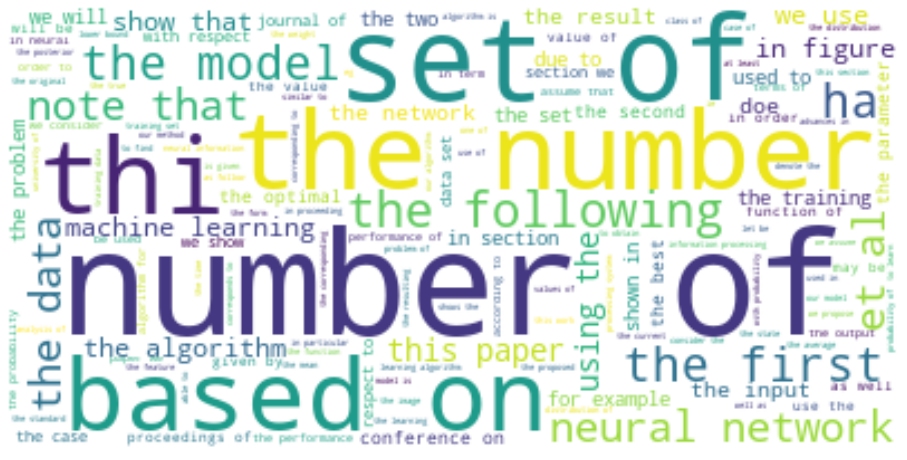

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16,12]

# Join the different processed tittles together
long_string = ','.join(list(papers['paper_text_processed'].values)) #Une a lo textos por comas

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
#wordcloud.to_image()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 4. Prepare text for LDA analysis

We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

In [25]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization
sns.set_style('whitegrid')
%matplotlib inline

In [26]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names() # get_feature_names() es una lista que contiene todas las words
    total_counts = np.zeros(len(words)) # Se crea un array con la longitud de words
    for t in count_data:
        total_counts+=t.toarray()[0]  # Se llena con numeros el array anterior de acuerdo a la ocurrencia
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10] # Top 10
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

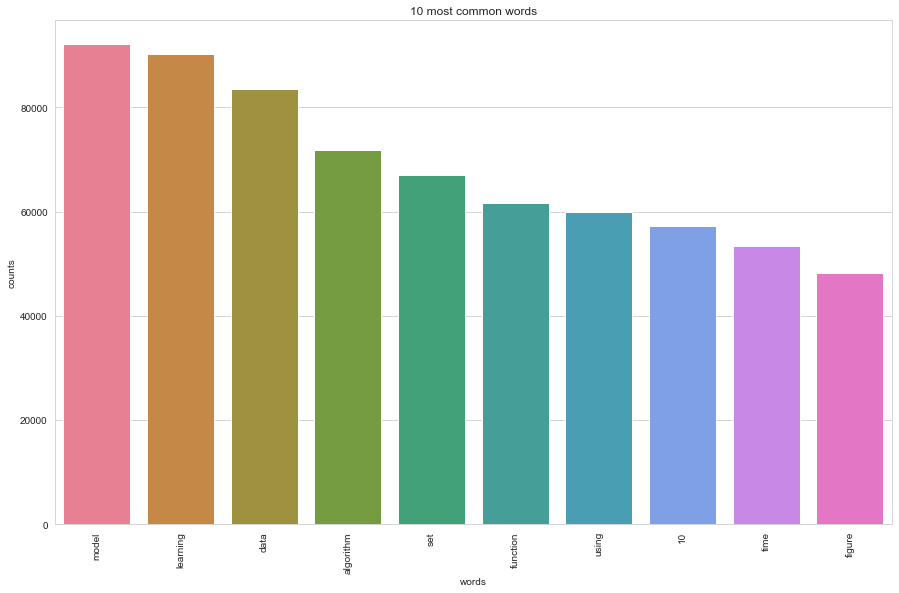

In [27]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### 5. LDA model training

In [29]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) # argsort() returns the index position of a sorted array
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
image model training images using network neural data networks learning

Topic #1:
model data models distribution time using state inference 10 set

Topic #2:
network learning model time neural input figure neurons state networks

Topic #3:
data learning set matrix kernel problem algorithm 10 using xi

Topic #4:
algorithm function learning problem set theorem bound error log let


In [28]:
# Ejemplo de lo que hace la funcion argsort()
arr = np.array([100,200,1])
print(arr)
print(arr.argsort()) # argsort() returns the index position of a sorted array

[100 200   1]
[2 0 1]


### 6. Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [37]:
%%time

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

Wall time: 4min 14s


In [38]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.103426  0.044123       1        1  24.669437
1      0.031436  0.038338       2        1  21.403140
3      0.073049 -0.055037       3        1  20.526299
2     -0.133018  0.065410       4        1  18.680937
0     -0.074893 -0.092833       5        1  14.720187, topic_info=               Term          Freq         Total Category  logprob  loglift
147817        image  25600.000000  25600.000000  Default  30.0000  30.0000
183311        model  90695.000000  90695.000000  Default  29.0000  29.0000
189047      network  38086.000000  38086.000000  Default  28.0000  28.0000
147880       images  16664.000000  16664.000000  Default  27.0000  27.0000
189193       neural  36202.000000  36202.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
108514    different   6594.356613  31282.074199   Topic5  -5.8528   0.3591
203850  performance   6358.028284  27674.977085   Topic5  -5.8893   0.4451
81025         based   6299.648708  37044.206818   Topic5  -5.8985   0.1443
193546       number   5806.547963  46908.470233   Topic5  -5.9800  -0.1733
10487            10   5829.450513  56291.659046   Topic5  -5.9761  -0.3517

[506 rows x 6 columns], token_table=        Topic      Freq  Term
term                         
10487       1  0.252897    10
10487       2  0.233001    10
10487       3  0.266292    10
10487       4  0.144249    10
10487       5  0.103550    10
...       ...       ...   ...
271217      2  0.265752    xt
271217      3  0.059292    xt
271217      4  0.028503    xt
271217      5  0.018947    xt
275389      3  0.988125  zien

[1354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])